# **FactoryIQ: ML-Driven Supplier Defect Impact Predictor**

# Project Objective
To develop a machine learning solution that predicts the total downtime (in minutes) arising from supplier-related quality defects at manufacturing plants. The project aims to provide actionable insights for minimizing operational losses, guiding resource allocation, and informing supplier quality management across a multi-plant manufacturing network.

## Business Problem
Supplier defects lead to unplanned production downtime in manufacturing plants, incurring substantial costs and disrupting delivery schedules. The company operates multiple plants in different locations, each producing various categories of products and sourcing materials from a diverse supplier base. Despite ongoing efforts, downtime caused by quality defects remains unpredictable and unevenly distributed across plants and product categories. Business leaders need to:

- Pinpoint which plant locations and product categories experience the highest downtime due to supplier defects
- Proactively plan interventions and allocate quality assurance resources to locations and products at greatest risk
- Enhance supplier vetting and development programs based on data-driven downtime risk assessments



---



### **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Economy-Supplier_Quality_Analysis_Dataset.xlsx to Economy-Supplier_Quality_Analysis_Dataset.xlsx


In [4]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Economy-Supplier_Quality_Analysis_Dataset.xlsx']))

In [5]:
# making a dataframe copy
batches = df.copy()

In [6]:
# display first 5 rows
batches.head()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
0,2013-04-13,Gabvine,Reading,MN,Logistics,Film,Impact,Damaged Secondary Packaging,326975.0,3252.0
1,2014-03-12,Linkbridge,Prescott,NY,Packaging,Film,No Impact,Foreign Material,NaN,2337.0
2,2013-09-28,Realpoint,Florence,IL,Mechanicals,Raw Materials,No Impact,Foreign objects found,82253.0,828.0
3,2013-04-17,Latz,Westside,NC,Logistics,Corrugate,Impact,Gap Variation,189966.0,1935.0
4,2013-03-13,Skiptube,Bruce Crossing,NJ,Goods & Services,Controllers,Rejected,Gap Variation,103577.0,1111.0


In [7]:
# last 5 rows
batches.tail()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
9995,2014-01-24,Bubblebox,Frazer,MT,Mechanicals,Corrugate,No Impact,Cracked,999759.0,5000.0
9996,2014-09-09,Brainbox,Riverside,MN,Logistics,Corrugate,Rejected,Incorrect Labeling,486620.0,4919.0
9997,2014-04-28,Demivee,New Britain,OH,Logistics,Raw Materials,Rejected,Warped,444030.0,4510.0
9998,2013-05-27,Eamia,Frazer,OR,Mechanicals,Film,Rejected,Wrong Fasteners,726718.0,5000.0
9999,2013-10-06,Feedfire,June Lake,NY,Mechanicals,Corrugate,Impact,String Defects,959926.0,5000.0


In [8]:
# checking info
batches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  object        
 2   Plant Location          10000 non-null  object        
 3   State                   10000 non-null  object        
 4   Category                10000 non-null  object        
 5   Material Type           10000 non-null  object        
 6   Defect Type             10000 non-null  object        
 7   Defect                  10000 non-null  object        
 8   Total Defect Qty        9589 non-null   float64       
 9   Total Downtime Minutes  9604 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 781.4+ KB


In [9]:
# checking null values
batches.isnull().sum()

,0
Date,0
Vendor,0
Plant Location,0
State,0
Category,0
Material Type,0
Defect Type,0
Defect,0
Total Defect Qty,411
Total Downtime Minutes,396


In [10]:
# shape of the df
print(f"Total rows are {batches.shape[0]} and Total columns are {batches.shape[1]}")

Total rows are 10000 and Total columns are 10


In [11]:
# Descriptive stats
batches.describe()

,Date,Total Defect Qty,Total Downtime Minutes
count,10000,9589.000000,9604.000000
mean,2014-01-01 01:59:39.840000,458852.493378,3358.459496
min,2013-01-01 00:00:00,5427.000000,86.000000
25%,2013-07-01 00:00:00,181533.000000,1843.000000
50%,2014-01-02 00:00:00,360887.000000,3627.000000
75%,2014-07-04 00:00:00,729132.000000,5000.000000
max,2014-12-30 00:00:00,999759.000000,5000.000000
std,NaN,326047.803718,1612.121097


#### Inferences from the Descriptive Statistics
Total Defect Qty:
- Ranges widely (5,427 to 999,759) and is highly variable.
- Right-skewed: most values are lower, but some very high, pulling up the mean.

Total Downtime Minutes:
- Also widely spread (86 to 5,000).
- Many records are capped at 5,000 minutes, possibly due to a business or synthetic data limit.

Data Quality:
- Some missing values exist, which should be imputed (median is recommended).

Implication:
- The data shows real-world-like variability and operational diversity, but frequent capping at 5,000 may affect extreme value modeling.

\

**Conclusion:**
Review the 5,000-minute cap, use median imputation for missing values, and be aware that predictions may be influenced by the high frequency of large downtime events.


In [12]:
# Descriptive stats of category features
batches.describe(include='object')

,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect
count,10000,10000,10000,10000,10000,10000,10000
unique,318,30,21,6,22,3,263
top,Izio,Riverside,MI,Mechanicals,Raw Materials,No Impact,Not Certified
freq,58,399,1787,3061,2925,3978,624


#### Inferences

- All columns have 10,000 entries, confirming data completeness for these fields.
- The dataset is diverse—especially for Vendor and Defect, with many unique values.
- Some columns are highly imbalanced, e.g., "Mechanicals" and "Raw Materials" dominate their categories.

This summary informs which features are high-cardinality (requiring careful encoding)

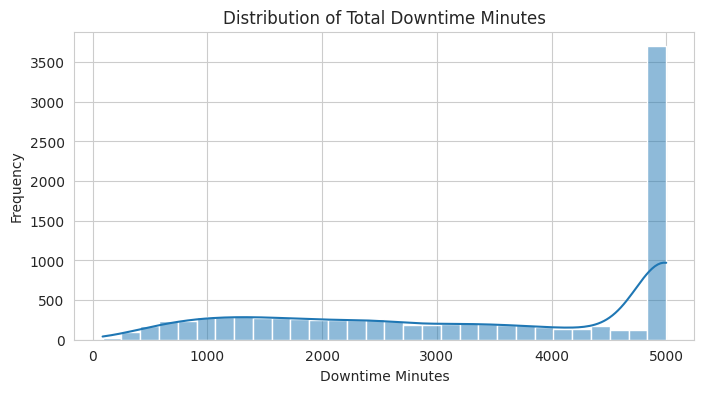

In [13]:
sns.histplot(batches['Total Downtime Minutes'], bins=30, kde=True)
plt.title('Distribution of Total Downtime Minutes')
plt.xlabel('Downtime Minutes')
plt.ylabel('Frequency')
plt.show()

- Most downtime events are short, but there is a pronounced spike at the maximum (5,000 minutes), suggesting a cap or limit in the data.
- The distribution is right-skewed with many minor incidents and a concentration of extreme values at the high end, reflecting real-world operational unpredictability and possible reporting or business limits.

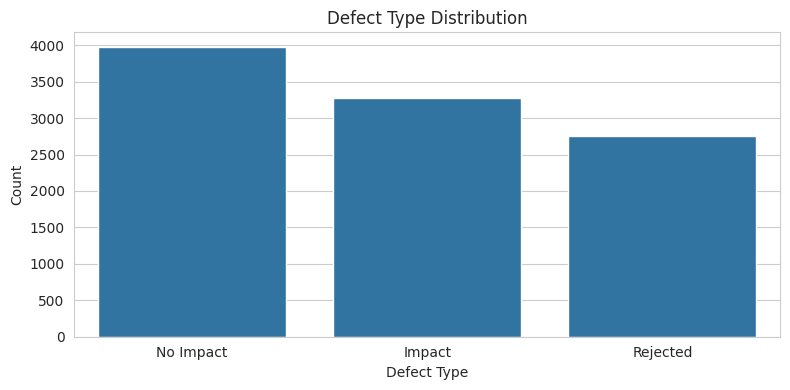

In [14]:
sns.countplot(data=batches, x='Defect Type', order=batches['Defect Type'].value_counts().index)
plt.title('Defect Type Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Most defects are "No Impact": These are common but don’t affect product performance.
- Serious defects ("Impact" and "Rejected") are less frequent but should receive special focus to avoid business risks.
- Action: Strengthen controls for severe defects while maintaining monitoring for all defect types. Optimize resource allocation based on defect severity.

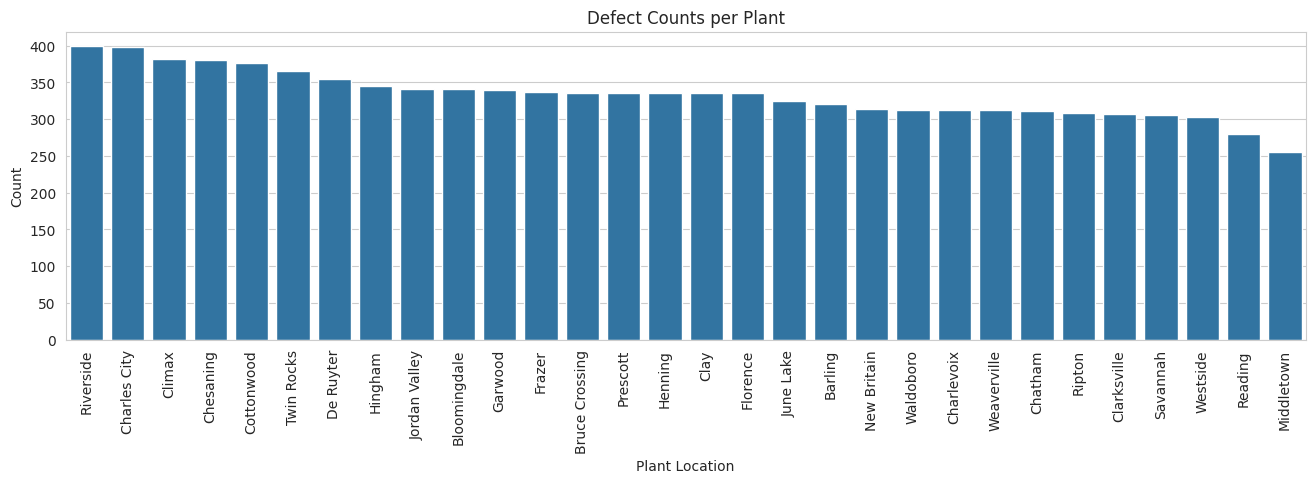

In [15]:
plt.figure(figsize=(16, 4))
sns.countplot(data=batches, x='Plant Location', order=batches['Plant Location'].value_counts().index)
plt.title('Defect Counts per Plant')
plt.xlabel('Plant Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

- Defects are high across all plants: Quality issues are widespread, not limited to a few locations.
- Top plants (like Riverside, Charles City, Twin Rocks) have the most defects: These should be prioritized for immediate improvement.
- Business action: Focus on system-wide process improvements and target the highest-count plants first for root cause analysis and quick wins.

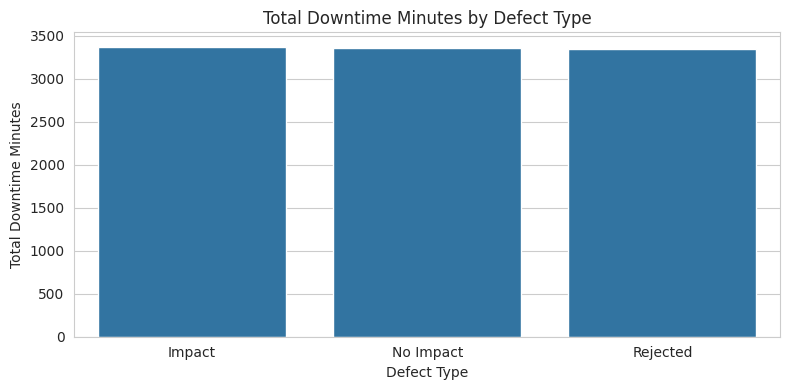

In [16]:
sns.barplot(data=batches, x='Defect Type', y='Total Downtime Minutes', ci=None)
plt.title('Total Downtime Minutes by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Total Downtime Minutes')
plt.tight_layout()
plt.show()

- All defect types ("No Impact", "Rejected", "Impact") contribute nearly equally to total downtime minutes.
- No single defect type dominates downtime, indicating that all types require attention for downtime reduction.
- Business action: Downtime improvement initiatives should address all defect areas rather than focusing on just one defect type. Broad, cross-category process optimization will yield the best results.

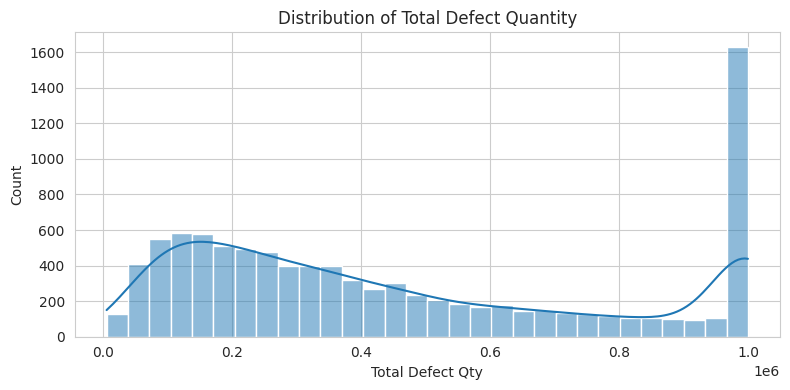

In [17]:
sns.histplot(batches['Total Defect Qty'], bins=30, kde=True)
plt.title('Distribution of Total Defect Quantity')
plt.xlabel('Total Defect Qty')
plt.tight_layout()
plt.show()

- The distribution is heavily right-skewed, showing most defect quantities are moderate, with many cases clustered at low values.
- There is a pronounced spike at the maximum defect quantity (around 1,000,000), indicating a potential data cap or reporting limit in the system.

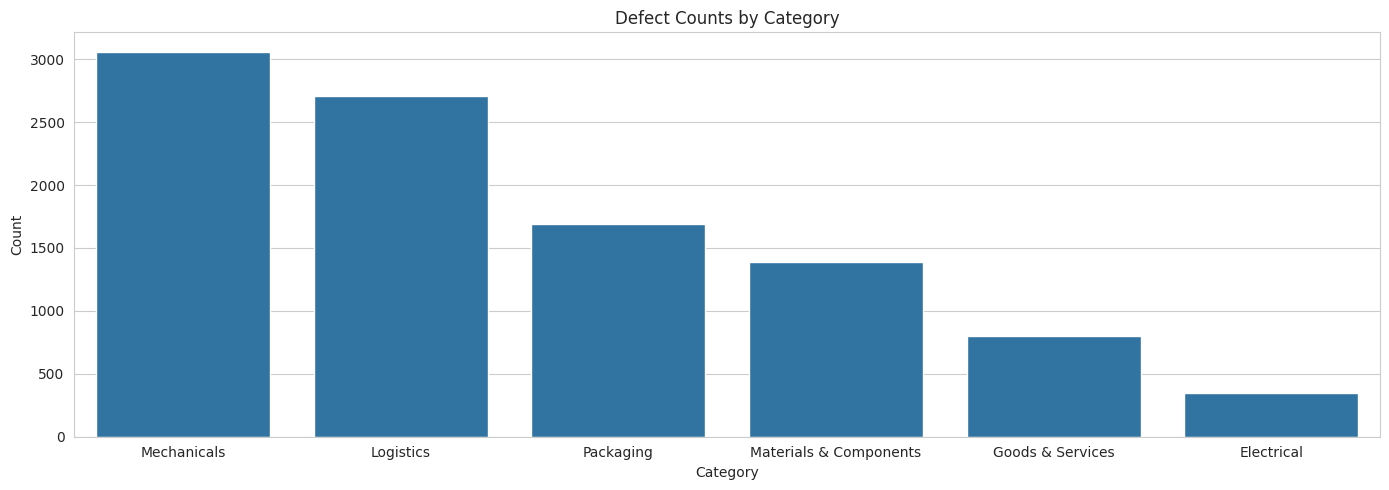

In [18]:
plt.figure(figsize=(14, 5))
sns.countplot(data=batches, x='Category', order=batches['Category'].value_counts().index)
plt.title('Defect Counts by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Mechanical and Logistics categories have the highest defect counts, indicating these are the main sources of quality issues.
- Packaging, Materials & Components contribute moderate defects, while Goods & Services and Electrical have the fewest.
- Business action: Focus improvement efforts first on Mechanical and Logistics processes to drive the greatest reduction in overall defects. Maintain ongoing monitoring of other categories to address any emerging issues.

#### **Recommendations:**
- Defects and downtime are common across all batches, plants, and defect types no specific outlier to target.
- Focus first on high-defect plants (like Riverside, Charles City, Twin Rocks) and categories (Mechanical, Logistics) for fastest improvement.
- "Impact" and "Rejected" types, though less frequent, can cause bigger issues tighten controls here.
- Since every defect type contributes to downtime, use company-wide process and maintenance initiatives, not narrow fixes.
- Track all quality patterns regularly and be ready to adapt if new trends emerge.
- Identify any top-performing plants or teams and replicate their successful practices across locations.

This approach maximizes quality gains, reduces risk, and drives efficiency across the entire business.



---



### **Data Cleaning**

In [19]:
batchesCln = batches.copy()

In [20]:
print(batchesCln['Total Defect Qty'].median())
print(batchesCln['Total Downtime Minutes'].median())

360887.0
3627.0


In [21]:
batchesCln['Total Defect Qty'] = batchesCln['Total Defect Qty'].fillna(batchesCln['Total Defect Qty'].median())
batchesCln['Total Downtime Minutes'] = batchesCln['Total Downtime Minutes'].fillna(batchesCln['Total Downtime Minutes'].median())

In [22]:
batches.isnull().sum()

,0
Date,0
Vendor,0
Plant Location,0
State,0
Category,0
Material Type,0
Defect Type,0
Defect,0
Total Defect Qty,411
Total Downtime Minutes,396


In [23]:
batchesCln['Plant Location'].value_counts().sort_index()

,count
Plant Location,
Barling,320
Bloomingdale,341
Bruce Crossing,336
Charles City,398
Charlevoix,312
Chatham,311
Chesaning,380
Clarksville,307
Clay,335


In [24]:
batchesCln['Category'].value_counts()

,count
Category,
Mechanicals,3061
Logistics,2712
Packaging,1689
Materials & Components,1391
Goods & Services,797
Electrical,350


In [25]:
batchesCln['Material Type'].value_counts()

,count
Material Type,
Raw Materials,2925
Corrugate,2437
Film,830
Labels,706
Carton,661
Controllers,556
Batteries,434
Glass,315
Electrolytes,286


In [26]:
batchesCln['Defect'].value_counts()

,count
Defect,
Not Certified,624
Bad Seams,606
Misc,514
Foreign Material,401
Warped,279
...,...
Packaging Integrity,1
No Varnish,1
Poor Fit,1


In [27]:
listDefect = batchesCln['Defect'].unique()

In [28]:
#sort this list
listDefect.sort()
listDefect

array(['Assembly Issues', 'Bad Bearings', 'Bad Bond',
       'Bad Carton Packaging', 'Bad Cut', 'Bad Distribution',
       'Bad Fasteners', 'Bad Fill', 'Bad Film', 'Bad Finish', 'Bad Fit',
       'Bad Flaps', 'Bad Insert', 'Bad Labels', 'Bad Parameters',
       'Bad Print', 'Bad Seal', 'Bad Seams', 'Bad Shots', 'Bad Tiles',
       'Bad Tops', 'Bad Valves', 'Bad Welding', 'Blisters', 'Bowed',
       'Bowed/Warped', 'Broken Glass', 'Broken Valve Seal', 'Bubbling',
       'Burnt', 'Carton Delamination', 'Cartons Not Opening', 'Coating',
       'Codes Wrong', 'Color Deviation', 'Color Variation',
       'Component Failure', 'Components Stuck', 'Container Out of Spec',
       'Contamination', 'Corrugate Falling Apart', 'Crack', 'Cracked',
       'Creases / Wrinkles', 'Crooked', 'Crushed Sidewalls', 'Cut Box',
       'Cut Wires', 'Cuts', 'Damaged', 'Damaged Parts', 'Damaged Rolls',
       'Damaged Secondary Packaging', 'Damaged in Transit', 'Deep Slots',
       'Defective Packaging', 'Defect

In [29]:
def clean_defect_types(defect_series):
    cleaned = defect_series.str.replace(r"[^a-zA-Z0-9/ -]", "", regex=True)
    cleaned = cleaned.str.replace(r"\s*/\s*", "/", regex=True)
    cleaned = cleaned.str.replace(r"\s*-\s*", "-", regex=True)
    cleaned = cleaned.str.strip().str.replace(r"\s+", " ", regex=True)
    cleaned = cleaned.str.replace(r'\s+', ' ', regex=True).str.strip()
    return cleaned

In [30]:
batchesCln['Defect'] = clean_defect_types(batchesCln['Defect'])

In [31]:
batchesCln['Plant Location'] = batchesCln['Plant Location'].str.strip()
batchesCln['Category'] = batchesCln['Category'].str.strip()
batchesCln['Material Type'] = batchesCln['Material Type'].str.strip()
batchesCln['Defect'] = batchesCln['Defect'].str.strip()

In [32]:
batchesCln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  object        
 2   Plant Location          10000 non-null  object        
 3   State                   10000 non-null  object        
 4   Category                10000 non-null  object        
 5   Material Type           10000 non-null  object        
 6   Defect Type             10000 non-null  object        
 7   Defect                  10000 non-null  object        
 8   Total Defect Qty        10000 non-null  float64       
 9   Total Downtime Minutes  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 781.4+ KB




---



In [33]:
batchesCluster = batchesCln.copy()

In [34]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [35]:
# Step 1: Prepare the unique defect text data
unique_defects = batchesCluster['Defect'].unique().tolist()
print(f"Found {len(unique_defects)} unique defect descriptions to process.")

Found 262 unique defect descriptions to process.


In [36]:
# Step 2: Generate Text Embeddings
# We use a pre-trained model. 'all-MiniLM-L6-v2' is a great, lightweight choice

print("Loading sentence transformer model and generating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
defect_embeddings = model.encode(unique_defects, show_progress_bar=True)
print("Embeddings created. Shape:", defect_embeddings.shape)

Loading sentence transformer model and generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Embeddings created. Shape: (262, 384)


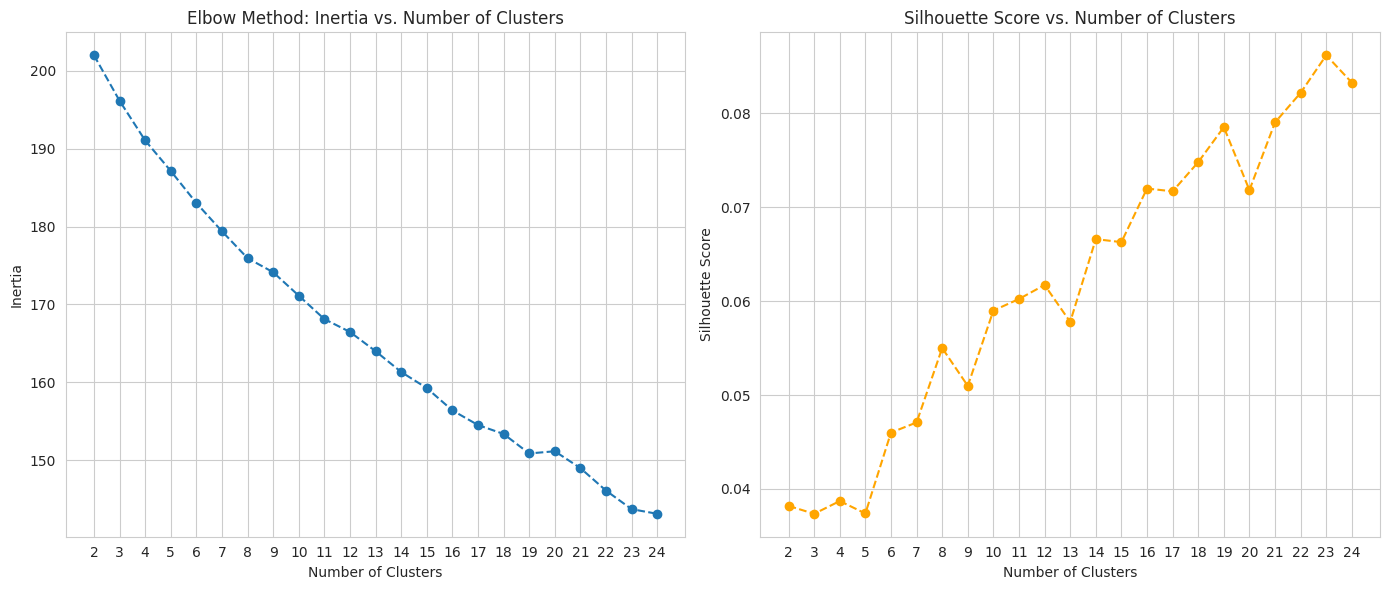

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assume defect_embeddings is your matrix of embeddings (e.g., output from SentenceTransformer)
k_range = range(2, 25)  # Testing from 2 to 25 clusters

inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(defect_embeddings)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(defect_embeddings, cluster_labels)
    silhouette_scores.append(score)

# Plotting the results
plt.figure(figsize=(14, 6))

# Elbow plot (Inertia)
plt.subplot(1, 2, 1)
plt.plot(list(k_range), inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(list(k_range))
plt.grid(True)

# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_range))
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
inertia

[201.99221801757812,
 196.15530395507812,
 191.05760192871094,
 187.14036560058594,
 183.0240020751953,
 179.398193359375,
 175.94166564941406,
 174.138427734375,
 171.12933349609375,
 168.12110900878906,
 166.4735107421875,
 164.00137329101562,
 161.3325958251953,
 159.2660369873047,
 156.40060424804688,
 154.52366638183594,
 153.37721252441406,
 150.8720703125,
 151.15672302246094,
 148.99127197265625,
 146.1061248779297,
 143.72190856933594,
 143.12786865234375]

In [39]:
silhouette_scores

[np.float32(0.0381977),
 np.float32(0.03735636),
 np.float32(0.03871395),
 np.float32(0.037390117),
 np.float32(0.046005294),
 np.float32(0.047084603),
 np.float32(0.05500818),
 np.float32(0.05098051),
 np.float32(0.059003025),
 np.float32(0.060236663),
 np.float32(0.06172697),
 np.float32(0.05779545),
 np.float32(0.06661227),
 np.float32(0.06629268),
 np.float32(0.07200019),
 np.float32(0.071704954),
 np.float32(0.0748108),
 np.float32(0.078540325),
 np.float32(0.07183513),
 np.float32(0.07904446),
 np.float32(0.08219614),
 np.float32(0.08619632),
 np.float32(0.08328499)]

- The inertia curve “elbow” is most apparent around 8-10 clusters. After this, the inertia declines slowly and nearly linearly, suggesting no major gain in cohesion from increasing K further.

- Silhouette scores peak progressively with more clusters, but most increases after K=13–15 are marginal, and higher K risks over-fragmentation, making clusters less actionable and possibly too small.

In [40]:
!pip install -q KeyBERT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00


In [41]:
from keybert import KeyBERT

# --- Step 1: Run K-Means with Your Chosen K ---
OPTIMAL_K = 8
print(f"Running K-Means with the chosen optimal K = {OPTIMAL_K}")

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans.fit(defect_embeddings)

Running K-Means with the chosen optimal K = 8


KMeans(n_init=10, random_state=42)

In [42]:
# Create a mapping from each unique defect description to its cluster ID (0-6)
defect_to_cluster_map = dict(zip(unique_defects, kmeans.labels_))
print("Clustering complete.")


#Step 2: Automatically Generate Cluster Names with KeyBERT
print("\nAutomatically Generating Cluster Names with KeyBERT.....")

# Initialize the KeyBERT model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# This dictionary will store our final names, e.g., {0: 'seam_and_seal_issue', 1: 'print_quality_defect', ...}
auto_cluster_names = {}

for i in range(OPTIMAL_K):
    # a. Get all defect descriptions for the current cluster
    cluster_defects = [defect for defect, cluster_id in defect_to_cluster_map.items() if cluster_id == i]

    # b. Join them into a single block of text to be summarized
    document = ". ".join(cluster_defects)

    # c. Extract the best descriptive phrase (1 to 3 words long)
    keywords = kw_model.extract_keywords(document,
                                         keyphrase_ngram_range=(1, 2),
                                         stop_words='english',
                                         top_n=1)

    # d. Get the generated name and clean it up for use as a column name
    if keywords:
        # Replace spaces with underscores and make it lowercase
        cluster_name = keywords[0][0].replace(' ', '_')
    else:
        cluster_name = f"cluster_{i}_unnamed" # Fallback name

    auto_cluster_names[i] = cluster_name

    print(f"Cluster {i}: Suggested Name = '{cluster_name}'")

Clustering complete.

Automatically Generating Cluster Names with KeyBERT.....
Cluster 0: Suggested Name = 'print_defects'
Cluster 1: Suggested Name = 'foreign_material'
Cluster 2: Suggested Name = 'misc_support'
Cluster 3: Suggested Name = 'defective_packaging'
Cluster 4: Suggested Name = 'crease_warped'
Cluster 5: Suggested Name = 'incorrect_color'
Cluster 6: Suggested Name = 'labels_incorrect'
Cluster 7: Suggested Name = 'defects_bad'


In [43]:
#Step 3: Create the Final DataFrame Column
print("\n--- Applying the new names to the DataFrame ---")

# a. First, create the column with the numerical cluster IDs
batchesCluster['Defect_Clusters'] = batchesCluster['Defect'].map(defect_to_cluster_map)

# b. Now, map these IDs to your newly generated names to create the final, human-readable column
batchesCluster['Defect_Category'] = batchesCluster['Defect_Clusters'].map(auto_cluster_names)

# c. Clean up by dropping the intermediate columns
batchesCluster_F = batchesCluster.drop(columns=['Defect_Clusters'])


--- Applying the new names to the DataFrame ---


In [44]:
batchesCluster_F.head()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes,Defect_Category
0,2013-04-13,Gabvine,Reading,MN,Logistics,Film,Impact,Damaged Secondary Packaging,326975.0,3252.0,defective_packaging
1,2014-03-12,Linkbridge,Prescott,NY,Packaging,Film,No Impact,Foreign Material,360887.0,2337.0,foreign_material
2,2013-09-28,Realpoint,Florence,IL,Mechanicals,Raw Materials,No Impact,Foreign objects found,82253.0,828.0,foreign_material
3,2013-04-17,Latz,Westside,NC,Logistics,Corrugate,Impact,Gap Variation,189966.0,1935.0,foreign_material
4,2013-03-13,Skiptube,Bruce Crossing,NJ,Goods & Services,Controllers,Rejected,Gap Variation,103577.0,1111.0,foreign_material


In [45]:
batchesCluster_F['Defect_Category'].value_counts()

,count
Defect_Category,
foreign_material,2174
misc_support,1958
defects_bad,1728
crease_warped,1405
incorrect_color,1163
defective_packaging,739
print_defects,552
labels_incorrect,281


In [46]:
batchesCluster_F.columns

Index(['Date', 'Vendor', 'Plant Location', 'State', 'Category',
       'Material Type', 'Defect Type', 'Defect', 'Total Defect Qty',
       'Total Downtime Minutes', 'Defect_Category'],
      dtype='object')

In [47]:
batchesCluster_F['Plant Location'].value_counts()

,count
Plant Location,
Riverside,399
Charles City,398
Climax,382
Chesaning,380
Cottonwood,376
Twin Rocks,366
De Ruyter,354
Hingham,345
Jordan Valley,341


In [48]:
batchesCluster_F['State'].value_counts()

,count
State,
MI,1787
NY,1256
PA,723
VA,699
MN,364
MA,357
OR,349
IL,340
AR,339


In [49]:
# Mapping of states to major U.S. regions
region_map = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast',
    'PA': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest',
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
    'SC': 'South', 'VA': 'South', 'WV': 'South', 'AL': 'South', 'KY': 'South',
    'MS': 'South', 'TN': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'TX': 'South',
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West',
    'UT': 'West', 'WY': 'West', 'CA': 'West', 'OR': 'West', 'WA': 'West'
}

# Add a new 'Region' column based on the state abbreviation
batchesCluster_F['Region'] = batchesCluster_F['State'].map(region_map)

# Preview the new columns
print(batchesCluster_F[['Plant Location', 'State', 'Region']].head())

   Plant Location State     Region
0         Reading    MN    Midwest
1        Prescott    NY  Northeast
2        Florence    IL    Midwest
3        Westside    NC      South
4  Bruce Crossing    NJ  Northeast


In [50]:
batchesCluster_F['Region'].value_counts()

,count
Region,
Northeast,3577
Midwest,3129
South,1972
West,1322


- Reduce Feature Cardinality: Combining plants by state or region lowers the number of unique values, which helps prevent overfitting and reduces model complexity.
- Reveal Regional Trends: Grouping may capture operational or supplier differences by geographical clusters (for example, Midwest vs. West vs. Northeast).
- Support Hierarchical Analysis: You can analyze or predict downtime patterns at multiple levels—plant, state, or region.

In [51]:
batchesCluster_F['Material Type'].value_counts()

,count
Material Type,
Raw Materials,2925
Corrugate,2437
Film,830
Labels,706
Carton,661
Controllers,556
Batteries,434
Glass,315
Electrolytes,286


**Clubbing Material Type:**
- Model Stability: Rare material types may lead to less reliable predictions and can cause overfitting if left as separate dummy variables or categories.
- Business Interpretability: Some materials (e.g., “Motors,” “Valves,” “Tape”) are too few to justify independent treatment and do not provide enough statistical power to identify meaningful trends.
- Improves Model Generalization: Reduces noise from rare categories.

In [52]:
# Define a function to group material types into broader categories
def group_material_feature(material):
    electrical_components = ['Controllers', 'Batteries', 'Motors', 'Drives']
    glass_composites = ['Glass', 'Composites', 'Electrolytes', 'Molds']
    packaging_related = ['Packaging', 'Tape', 'Crates', 'Printed Materials', 'Wires']
    other_rare = ['Mechanicals', 'Pump', 'Valves']

    if material in electrical_components:
        return 'Electrical Components'
    elif material in glass_composites:
        return 'Glass/Composites'
    elif material in packaging_related:
        return 'Packaging Related'
    elif material in other_rare:
        return 'Other'
    else:
        return material  # Keep common types like 'Raw Materials', 'Corrugate', etc.

# Apply this function to your actual DataFrame (assumed as df)
batchesCluster_F['Grouped Material Type'] = batchesCluster_F['Material Type'].apply(group_material_feature)

In [53]:
batchesCluster_F['Grouped Material Type'].value_counts()

,count
Grouped Material Type,
Raw Materials,2925
Corrugate,2437
Electrical Components,1126
Glass/Composites,1086
Film,830
Labels,706
Carton,661
Hardware,121
Packaging Related,80


In [54]:
#renaming column name
batchesCluster_F.rename(columns={'Defect Type': 'Defect_Type'}, inplace=True)
batchesCluster_F.rename(columns={'Material Type': 'Material_Type'}, inplace=True)
batchesCluster_F.rename(columns={'Total Defect Qty': 'Total_Defect_Qty'}, inplace=True)
batchesCluster_F.rename(columns={'Total Downtime Minutes': 'Total_Downtime_Minutes'}, inplace=True)
batchesCluster_F.rename(columns={'Plant Location': 'Plant_Location'}, inplace=True)
batchesCluster_F.rename(columns={'Grouped Material Type': 'Grouped_Material_Type'}, inplace=True)

In [55]:
batchesCluster_F.columns

Index(['Date', 'Vendor', 'Plant_Location', 'State', 'Category',
       'Material_Type', 'Defect_Type', 'Defect', 'Total_Defect_Qty',
       'Total_Downtime_Minutes', 'Defect_Category', 'Region',
       'Grouped_Material_Type'],
      dtype='object')

In [56]:
categorical_cols = [
    'Vendor', 'Plant_Location', 'State', 'Category', 'Material_Type', 'Defect_Type', 'Defect', 'Defect_Category', 'Region', 'Grouped_Material_Type']

for col in categorical_cols:
    batchesCluster_F[col] = batchesCluster_F[col].astype('category')

In [57]:
batchesCluster_F['Total_Defect_Qty'] = batchesCluster_F['Total_Defect_Qty'].astype('int64')
batchesCluster_F['Total_Downtime_Minutes'] = batchesCluster_F['Total_Downtime_Minutes'].astype('int64')

In [58]:
batchesCluster_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  category      
 2   Plant_Location          10000 non-null  category      
 3   State                   10000 non-null  category      
 4   Category                10000 non-null  category      
 5   Material_Type           10000 non-null  category      
 6   Defect_Type             10000 non-null  category      
 7   Defect                  10000 non-null  category      
 8   Total_Defect_Qty        10000 non-null  int64         
 9   Total_Downtime_Minutes  10000 non-null  int64         
 10  Defect_Category         10000 non-null  category      
 11  Region                  10000 non-null  category      
 12  Grouped_Material_Type   10000 non-null  categor



---

Removing unwanted columns: Date, Vendor, Plant_Location, State, Material_Type, Defect

In [59]:
batchesNew = batchesCluster_F.drop(columns=['Date', 'Vendor', 'Plant_Location', 'State', 'Material_Type', 'Defect'])

In [60]:
batchesNew.describe(include='category')

,Category,Defect_Type,Defect_Category,Region,Grouped_Material_Type
count,10000,10000,10000,10000,10000
unique,6,3,8,4,10
top,Mechanicals,No Impact,foreign_material,Northeast,Raw Materials
freq,3061,3978,2174,3577,2925




---



In [61]:
# value_counts of all categorical features datatype
for col in batchesNew.select_dtypes(include='category').columns:
    print(f"Value counts for {col}:")
    print(batchesNew[col].value_counts())
    print("\n")

Value counts for Category:
Category
Mechanicals               3061
Logistics                 2712
Packaging                 1689
Materials & Components    1391
Goods & Services           797
Electrical                 350
Name: count, dtype: int64


Value counts for Defect_Type:
Defect_Type
No Impact    3978
Impact       3271
Rejected     2751
Name: count, dtype: int64


Value counts for Defect_Category:
Defect_Category
foreign_material       2174
misc_support           1958
defects_bad            1728
crease_warped          1405
incorrect_color        1163
defective_packaging     739
print_defects           552
labels_incorrect        281
Name: count, dtype: int64


Value counts for Region:
Region
Northeast    3577
Midwest      3129
South        1972
West         1322
Name: count, dtype: int64


Value counts for Grouped_Material_Type:
Grouped_Material_Type
Raw Materials            2925
Corrugate                2437
Electrical Components    1126
Glass/Composites         1086
Film      

In [62]:
batchesModel = batchesNew.copy()

In [63]:
from sklearn.model_selection import train_test_split

X = batchesModel.drop('Total_Downtime_Minutes', axis=1)
y = batchesModel['Total_Downtime_Minutes']

# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% test size
    random_state=42
)

**Defect_Category**
- This column has several sizeable but also some rare categories.
- It is a primary driver of your business question (defects and their impact on downtime).
- Ensures all defect groups are represented during both training and evaluation.

In [64]:
# Check that the stratification was successful
print("Defect_Category distribution in training set:")
print(X_train['Defect_Category'].value_counts(normalize=True))
print("\nDefect_Category distribution in test set:")
print(X_test['Defect_Category'].value_counts(normalize=True))

Defect_Category distribution in training set:
Defect_Category
foreign_material       0.213625
misc_support           0.197375
defects_bad            0.176125
crease_warped          0.140750
incorrect_color        0.117625
defective_packaging    0.073000
print_defects          0.052000
labels_incorrect       0.029500
Name: proportion, dtype: float64

Defect_Category distribution in test set:
Defect_Category
foreign_material       0.2325
misc_support           0.1895
defects_bad            0.1595
crease_warped          0.1395
incorrect_color        0.1110
defective_packaging    0.0775
print_defects          0.0680
labels_incorrect       0.0225
Name: proportion, dtype: float64


In [65]:
X_train.head()

,Category,Defect_Type,Total_Defect_Qty,Defect_Category,Region,Grouped_Material_Type
9254,Materials & Components,No Impact,54577,print_defects,Northeast,Corrugate
1561,Materials & Components,Impact,404458,defects_bad,Midwest,Carton
1670,Logistics,Impact,520004,print_defects,Northeast,Raw Materials
6087,Logistics,Rejected,212679,crease_warped,West,Glass/Composites
6669,Packaging,No Impact,999759,crease_warped,Northeast,Corrugate




---



In [66]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
categorical_features = X_train.select_dtypes(include='category').columns
numerical_features = X_train.select_dtypes(exclude='category').columns

In [68]:
# Initialize encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Fit ONLY on training data
encoder.fit(X_train[categorical_features])

# Transform both datasets
X_train_encoded = encoder.transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])  # uses same mapping as training

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])     # Fit ONLY on X_train

X_train_num = scaler.transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Step 4: Combine both parts
X_train_processed = np.hstack([X_train_num, X_train_encoded])
X_test_processed = np.hstack([X_test_num, X_test_encoded])

In [70]:
# Step 1: Get feature names from the encoder
encoded_cat_feature_names = encoder.get_feature_names_out(categorical_features)

# Step 2: Combine all feature names (scaled numeric + one-hot encoded categorical)
final_feature_names = list(numerical_features) + list(encoded_cat_feature_names)

# Step 3: Convert NumPy arrays to DataFrames with proper column names and indices
X_train_final = pd.DataFrame(X_train_processed, columns=final_feature_names, index=X_train.index)
X_test_final = pd.DataFrame(X_test_processed, columns=final_feature_names, index=X_test.index)

In [71]:
print(X_train_final.shape)
print(X_test_final.shape)

(8000, 27)
(2000, 27)




---



In [72]:
import statsmodels.api as sm

In [74]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Add constant (intercept) to train and test sets
X_train_ols = sm.add_constant(X_train_final)
X_test_ols = sm.add_constant(X_test_final)

# Fit OLS model on training data
ols_model = sm.OLS(y_train, X_train_ols)
results = ols_model.fit()

# Print model summary
print(results.summary())

# Make predictions
y_train_pred_lr = results.predict(X_train_ols)
y_test_pred_lr = results.predict(X_test_ols)

# Calculate MSE and RMSE for training data
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mse_train_lr)

# Calculate MSE and RMSE for test data
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
rmse_test_lr = np.sqrt(mse_test_lr)

# Output results
print(f"Train MSE: {mse_train_lr:.4f}, RMSE: {rmse_train_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, RMSE: {rmse_test_lr:.4f}")

                              OLS Regression Results                              
Dep. Variable:     Total_Downtime_Minutes   R-squared:                       0.722
Model:                                OLS   Adj. R-squared:                  0.721
Method:                     Least Squares   F-statistic:                     765.9
Date:                    Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                            17:59:18   Log-Likelihood:                -65148.
No. Observations:                    8000   AIC:                         1.304e+05
Df Residuals:                        7972   BIC:                         1.305e+05
Df Model:                              27                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

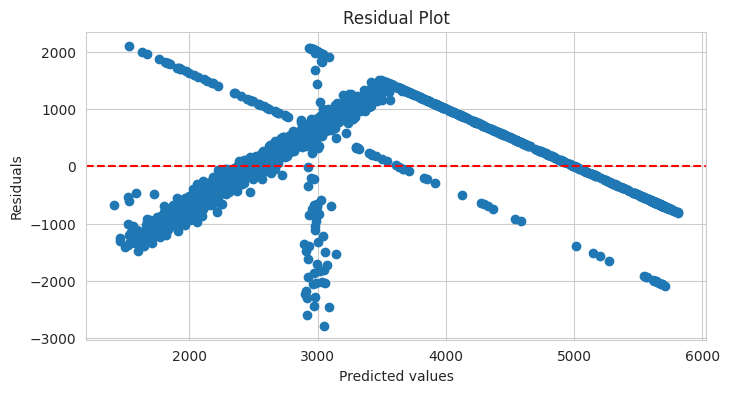

In [75]:
# after fitting your model
residuals = y_test - y_test_pred_lr

# Residual plot
plt.scatter(y_test_pred_lr, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Linear Regression Doesn't Fit Well

- Non-linear patterns in residuals, model is missing complexity.
- Changing spread of residuals → possible heteroscedasticity.
- Clustered residuals → likely issues with categorical encoding or hidden interactions.

JB Test Result:
- Prob(JB) ≈ 0, Residuals are not normal, another sign linear regression isn't valid here.





---



In [76]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [77]:
def evaluate_and_print(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    print(f"{name} Performance:")
    print(f"Train MAE: {mae_train:.2f}, Train RMSE: {rmse_train:.2f}")
    print(f"Test  MAE: {mae_test:.2f}, Test  RMSE: {rmse_test:.2f}")
    print(f"Train R^2: {r2_train:.2f}")
    print(f"Test  R^2: {r2_test:.2f}\n")

In [78]:
models = [
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting (GBM)", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
]

In [79]:
#  Pipeline execution (run this block to get all results)
for name, model in models:
    evaluate_and_print(model, X_train_final, y_train, X_test_final, y_test, name)

Decision Tree Performance:
Train MAE: 11.08, Train RMSE: 107.12
Test  MAE: 235.85, Test  RMSE: 677.35
Train R^2: 1.00
Test  R^2: 0.82

Random Forest Performance:
Train MAE: 78.46, Train RMSE: 204.26
Test  MAE: 207.96, Test  RMSE: 524.83
Train R^2: 0.98
Test  R^2: 0.89

AdaBoost Performance:
Train MAE: 315.92, Train RMSE: 505.32
Test  MAE: 327.34, Test  RMSE: 525.90
Train R^2: 0.90
Test  R^2: 0.89

Gradient Boosting (GBM) Performance:
Train MAE: 170.00, Train RMSE: 434.29
Test  MAE: 190.32, Test  RMSE: 487.61
Train R^2: 0.92
Test  R^2: 0.91

XGBoost Performance:
Train MAE: 132.39, Train RMSE: 308.68
Test  MAE: 230.30, Test  RMSE: 530.08
Train R^2: 0.96
Test  R^2: 0.89





---



In [80]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.4 MB/s eta 0:00:00


In [81]:
import optuna

**GBM**

In [82]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model_gbm = GradientBoostingRegressor(**params, random_state=42)
    # model.fit(X_train_final, y_train)
    # preds = model.predict(X_test_final)
    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # return rmse

    # Evaluate with 5-fold cross-validation and return the mean RMSE
    cv_scores = cross_val_score(
        model_gbm,
        X_train_final, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    return -cv_scores.mean()  # Negative because Optuna minimizes; scoring returns negative RMSE

# Optuna study for parameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-07-23 18:23:26,094] A new study created in memory with name: no-name-8d20cfbf-de59-442e-aaa8-fef599de9a95
[I 2025-07-23 18:24:46,833] Trial 0 finished with value: 555.7082300903678 and parameters: {'n_estimators': 700, 'learning_rate': 0.10042367524663945, 'max_depth': 9, 'subsample': 0.9173801355692011, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 555.7082300903678.
[I 2025-07-23 18:24:56,005] Trial 1 finished with value: 463.0657374960213 and parameters: {'n_estimators': 200, 'learning_rate': 0.10440566031747342, 'max_depth': 4, 'subsample': 0.7938496327462096, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 463.0657374960213.
[I 2025-07-23 18:25:08,434] Trial 2 finished with value: 497.56134116643636 and parameters: {'n_estimators': 600, 'learning_rate': 0.09984345153386837, 'max_depth': 6, 'subsample': 0.8484671036723284, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max

In [83]:
# Print the best found parameters
print("Best Parameters:", study.best_params)

# Fit final model with the best parameters
best_params = study.best_params
final_model_gbm = GradientBoostingRegressor(**best_params, random_state=42)
final_model_gbm.fit(X_train_final, y_train)

# Predict for both sets
y_train_pred_gbm = final_model_gbm.predict(X_train_final)
y_test_pred_gbm = final_model_gbm.predict(X_test_final)

# Calculate metrics
mse_train_gbm = mean_squared_error(y_train, y_train_pred_gbm)
rmse_train_gbm = np.sqrt(mean_squared_error(y_train, y_train_pred_gbm))
r2_train_gbm = r2_score(y_train, y_train_pred_gbm)

mse_test_gbm = mean_squared_error(y_test, y_test_pred_gbm)
rmse_test_gbm = np.sqrt(mean_squared_error(y_test, y_test_pred_gbm))
r2_test_gbm = r2_score(y_test, y_test_pred_gbm)

print(f"Train MSE: {mse_train_gbm:.4f}, RMSE: {rmse_train_gbm:.4f}, R²: {r2_train_gbm:.4f}")
print(f"Test  MSE: {mse_test_gbm:.4f}, RMSE: {rmse_test_gbm:.4f}, R²: {r2_test_gbm:.4f}")

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.04078703751222601, 'max_depth': 3, 'subsample': 0.7425456197523563, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}
Train MSE: 199358.2243, RMSE: 446.4955, R²: 0.9200
Test  MSE: 233375.0354, RMSE: 483.0891, R²: 0.9075




---



**XGB**

In [84]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'verbosity': 0
    }

    model_xgb = XGBRegressor(**params)
    # model.fit(X_train_final, y_train)
    # preds = model.predict(X_test_final)
    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # return rmse

    # Evaluate with 5-fold cross-validation and return the mean RMSE
    cv_scores = cross_val_score(
        model_xgb,
        X_train_final, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    return -cv_scores.mean()  # Negative because Optuna minimizes; scoring returns negative RMSE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_params)

[I 2025-07-23 18:34:44,738] A new study created in memory with name: no-name-7591376a-dc0e-4f94-96ad-a8d1e3cedce6
[I 2025-07-23 18:34:53,763] Trial 0 finished with value: 489.2400146484375 and parameters: {'n_estimators': 600, 'learning_rate': 0.04396011683073627, 'max_depth': 10, 'subsample': 0.9239422572870903, 'colsample_bytree': 0.6086184581907665, 'min_child_weight': 9, 'gamma': 2.930793934048253, 'reg_alpha': 1.0355727921493996, 'reg_lambda': 9.855984979355785}. Best is trial 0 with value: 489.2400146484375.
[I 2025-07-23 18:35:08,759] Trial 1 finished with value: 535.3584716796875 and parameters: {'n_estimators': 1000, 'learning_rate': 0.039743536065206045, 'max_depth': 12, 'subsample': 0.9728018179255364, 'colsample_bytree': 0.6721623813750244, 'min_child_weight': 6, 'gamma': 0.3422186477110972, 'reg_alpha': 9.43788079849469, 'reg_lambda': 2.0079528107051328}. Best is trial 0 with value: 489.2400146484375.
[I 2025-07-23 18:35:10,951] Trial 2 finished with value: 457.62890625 an

{'n_estimators': 250, 'learning_rate': 0.027822880398896493, 'max_depth': 3, 'subsample': 0.7896640833876843, 'colsample_bytree': 0.7958168619809642, 'min_child_weight': 1, 'gamma': 3.394810321817568, 'reg_alpha': 5.4843229172748735, 'reg_lambda': 8.690076341689181}


In [85]:
# Print the best found parameters
print("Best Parameters:", study.best_params)

# Fit final model with the best parameters
best_params = study.best_params
final_model_xgb = XGBRegressor(**best_params, random_state=42)
final_model_xgb.fit(X_train_final, y_train)

# Predict for both sets
y_train_pred_xgb = final_model_xgb.predict(X_train_final)
y_test_pred_xgb = final_model_xgb.predict(X_test_final)

# Calculate metrics
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"Train MSE: {mse_train_xgb:.4f}, RMSE: {rmse_train_xgb:.4f}, R²: {r2_train_xgb:.4f}")
print(f"Test  MSE: {mse_test_xgb:.4f}, RMSE: {rmse_test_xgb:.4f}, R²: {r2_test_xgb:.4f}")

Best Parameters: {'n_estimators': 250, 'learning_rate': 0.027822880398896493, 'max_depth': 3, 'subsample': 0.7896640833876843, 'colsample_bytree': 0.7958168619809642, 'min_child_weight': 1, 'gamma': 3.394810321817568, 'reg_alpha': 5.4843229172748735, 'reg_lambda': 8.690076341689181}
Train MSE: 198511.6875, RMSE: 445.5465, R²: 0.9203
Test  MSE: 233792.3594, RMSE: 483.5208, R²: 0.9074


In [86]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
result_xgb = mape(y_test, y_test_pred_xgb)
accuracy_xgb = 100 - result_xgb
print(f"MAPE for XGBoost: {result_xgb:.2f}%")
print(f"Regression Accuracy XGBoost: {accuracy_xgb:.2f}%")

MAPE for XGBoost: 11.40%
Regression Accuracy XGBoost: 88.60%


In [88]:
importances = final_model_xgb.feature_importances_
features_names = final_model_xgb.feature_names_in_

feat_imp_df = pd.DataFrame({'feature': features_names, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False, inplace=True)

feat_imp_df

,feature,importance
0,Total_Defect_Qty,0.920537
26,Grouped_Material_Type_Raw Materials,0.007216
19,Grouped_Material_Type_Electrical Components,0.006587
2,Category_Logistics,0.004124
21,Grouped_Material_Type_Glass/Composites,0.004112
8,Defect_Category_defective_packaging,0.004009
13,Defect_Category_misc_support,0.003827
22,Grouped_Material_Type_Hardware,0.003721
18,Grouped_Material_Type_Corrugate,0.003709
16,Region_South,0.003084




---



In [89]:
np.array(X_test_final.iloc[1451,:])

array([0.22353644, 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [90]:
final_model_xgb.predict([X_test_final.iloc[1451,:]])

array([4952.4873], dtype=float32)

In [91]:
y_test.iloc[1451]

np.int64(5000)

In [92]:
X_test_final.iloc[1451,:]

,3889
Total_Defect_Qty,0.223536
Category_Goods & Services,1.000000
Category_Logistics,0.000000
Category_Materials & Components,0.000000
Category_Mechanicals,0.000000
Category_Packaging,0.000000
Defect_Type_No Impact,0.000000
Defect_Type_Rejected,0.000000
Defect_Category_defective_packaging,1.000000
Defect_Category_defects_bad,0.000000




---



In [93]:
# import pickle

# # Save both model and scaler together
# with open('final_model_xgb.pkl', 'wb') as f:
#     pickle.dump((scaler, final_model_xgb), f)

# from google.colab import files
# files.download('final_model_xgb.pkl')

# **END**